In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from ysdc_dataset_api.dataset import MotionPredictionDataset
from ysdc_dataset_api.features import FeatureRenderer
from ysdc_dataset_api.utils import get_file_paths, scenes_generator, transform2dpoints

## Raw data

In [2]:
dataset_path = '/path/to/dataset/train/'
filepaths = get_file_paths(dataset_path)

In [3]:
scene = next(scenes_generator(filepaths))

In [4]:
# Number of known history steps
# Index 0 is farthest (-5s) into the past, and index 24 represents current time
print('Number of history steps:', len(scene.past_vehicle_tracks))

Number of history steps: 25


In [5]:
print('Number of vehicles seen at current time:', len(scene.past_vehicle_tracks[-1].tracks))
print(scene.past_vehicle_tracks[-1].tracks)

Number of vehicles seen at current time: 1
[track_id: 3923
position {
  x: -2019.9418656865134
  y: 1085.4598225149823
  z: 0.9818075703291762
}
dimensions {
  x: 4.529175540519738
  y: 2.0547066458659815
  z: 1.968017719989121
}
linear_velocity {
  x: 9.722125739413503
  y: -9.368845936458117
}
linear_acceleration {
  x: -0.2929295908623673
  y: 0.6188691794027462
}
yaw: 2.3747944352334356
]


In [6]:
print('Number of pedestrians seen at current time:', len(scene.past_pedestrian_tracks[-1].tracks))
print(scene.past_pedestrian_tracks[-1].tracks)

Number of pedestrians seen at current time: 0
[]


In [7]:
print('Number of vehicles to predict:', len(scene.prediction_requests))
print(scene.prediction_requests)

Number of vehicles to predict: 1
[track_id: 3923
trajectory_tags: kUniform
trajectory_tags: kMoveForward
]


In [8]:
# Number of future steps
# Index 0 is closest (0.2s into the future), index 24 is farthest (5s into the future)
print('Number of future steps to predict:', len(scene.future_vehicle_tracks))

Number of future steps to predict: 25


In [9]:
print('First future state:', scene.future_vehicle_tracks[0].tracks)

First future state: [track_id: 3923
position {
  x: -2017.8681271961125
  y: 1083.6118504585602
  z: 1.0
}
dimensions {
  x: 4.437810497232245
  y: 2.002603740226932
  z: 2.0
}
linear_velocity {
  x: 10.613095687628794
  y: -9.557546072252253
}
linear_acceleration {
  x: 0.5709183894738626
  y: -0.3332869578985755
}
yaw: 2.3381289968105037
]


In [10]:
print('Last future state:', scene.future_vehicle_tracks[24].tracks)

Last future state: [track_id: 3923
position {
  x: -1968.395917069477
  y: 1036.1632503195
  z: 0.8644047462812844
}
dimensions {
  x: 4.44663464288366
  y: 2.0053597653181865
  z: 1.7400477229576077
}
linear_velocity {
  x: 10.495274410037208
  y: -10.680511872289703
}
linear_acceleration {
  x: -0.16880430160665374
  y: -0.46839964155131236
}
yaw: -0.7920735653804467
]


## Basic usage

In [11]:
renderer_config = {
    # parameters of feature maps to render
    'feature_map_params': {
        'rows': 400,
        'cols': 400,
        'resolution': 0.25,  # number of meters in one pixel
    },
    'renderers_groups': [
        # Having several feature map groups
        # allows to independently render feature maps with different history length.
        # This could be useful to render static features (road graph, etc.) once.
        # Renderer for static features is under development.
        {
            # start: int, first timestamp into the past to render, 0 – prediction time
            # stop: int, last timestamp to render inclusively, 24 – farthest known point into the past
            # step: int, grid step size,
            #            step=1 renders all points between start and stop,
            #            step=2 renders every second point, etc.
            'time_grid_params': {
                'start': 0,
                'stop': 0,
                'step': 1,
            },
            'renderers': [
                # each value is rendered at its own channel
                # occupancy -- 1 channel
                # velocity -- 2 channels (x, y)
                # acceleration -- 2 channels (x, y)
                # yaw -- 1 channel
                {'vehicles': ['occupancy', 'velocity', 'acceleration', 'yaw']},
                # only occupancy and velocity are available for pedestrians
                {'pedestrians': ['occupancy', 'velocity']},
            ]
        }
    ]
}

In [12]:
# path to dataset dir containing sub directories
dataset_path = '/path/to/dataset/train/'
# path to file with scene tags
scene_tags_fpath = '/path/to/dataset/train_tags_file'

In [13]:
renderer = FeatureRenderer(renderer_config)

In [14]:
renderer.to_feature_map_tf

array([[  4.,   0.,   0., 200.],
       [  0.,   4.,   0., 200.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]])

In [15]:
dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    feature_producer=renderer,
    transform_ground_truth_to_agent_frame=True,
)

In [16]:
# Number of scenes in dataset.
# Actual number of objects in dataset is bigger,
# since we consider multiple agents in a scene for prediction.
dataset.num_scenes

50000

In [17]:
dataset_iter = iter(dataset)

In [18]:
# Take some scene
for i in range(10):
    data_item = next(dataset_iter)

In [19]:
# One data item contains rendered feature maps and ground truth trajectory.
# Feature maps are centered around current actor.
# Ground truth trajectory is transformed to actor coordinate system:
# actor is located at origin (0, 0) headed to positive x direction  at prediction time.
data_item.keys()

dict_keys(['ground_truth_trajectory', 'feature_maps'])

In [20]:
# Feature maps are in channels first format
data_item['feature_maps'].shape

(9, 400, 400)

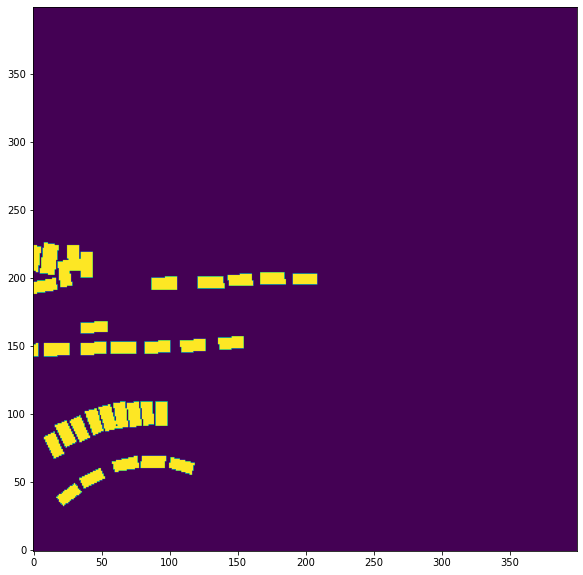

In [21]:
# Plot vehicles occupancy
plt.figure(figsize=(10, 10))
plt.imshow(data_item['feature_maps'][0], origin='lower')

## Filtration by tags

In [22]:
# To filter scenes by tags one should specify a filter function
# Scene tags dict has following structure:
# {
#     'day_time': one of {'kNight', 'kMorning', 'kAfternoon', 'kEvening'}
#     'season': one of {'kWinter', 'kSpring', 'kSummer', 'kAutumn'}
#     'track': one of {'Moscow' , 'Skolkovo', 'Innopolis', 'AnnArbor', 'Modiin', 'TelAviv'}
#     'sun_phase': one of {'kAstronomicalNight', 'kTwilight', 'kDaylight'}
#     'precipitation': one of {'kNoPrecipitation', 'kRain', 'kSleet', 'kSnow'}
# }
# Full description of protobuf message is available at tags.proto file in sources


def filter_scene(scene_tags_dict):
    if scene_tags_dict['track'] == 'AnnArbor' and scene_tags_dict['precipitation'] == 'kRain':
        return True
    else:
        return False

In [23]:
# Trajectory tags list can include any number of the following non-mutually exclusive tags.
# [
#     'kMoveLeft', 'kMoveRight', 'kMoveForward', 'kMoveBack',
#     'kAcceleration', 'kDeceleration', 'kUniform',
#     'kStopping', 'kStarting', 'kStationary'
# ]


def filter_trajectory(trajectory_tags_list):
    if 'kMoveRight' in trajectory_tags_list:
        return True
    else:
        return False

In [24]:
# Let's try to filter scenes

dataset = MotionPredictionDataset(
    dataset_path=dataset_path,
    scene_tags_fpath=scene_tags_fpath,
    feature_producer=renderer,
    transform_ground_truth_to_agent_frame=True,
    scene_tags_filter=filter_scene,
    trajectory_tags_filter=filter_trajectory,
)

In [25]:
# Rainy Ann-Arbor is pretty rare occasion
dataset.num_scenes

364

In [26]:
dataset_iter = iter(dataset)

In [27]:
for i in range(10):
    data_item = next(dataset_iter)

In [28]:
vehicles_occupancy_fm = data_item['feature_maps'][0]

In [29]:
transformed_gt = transform2dpoints(data_item['ground_truth_trajectory'], renderer.to_feature_map_tf)
transformed_gt = np.round(transformed_gt - 0.5).astype(np.int32)
vehicles_occupancy_fm = cv2.polylines(vehicles_occupancy_fm, [transformed_gt], False, 1.)

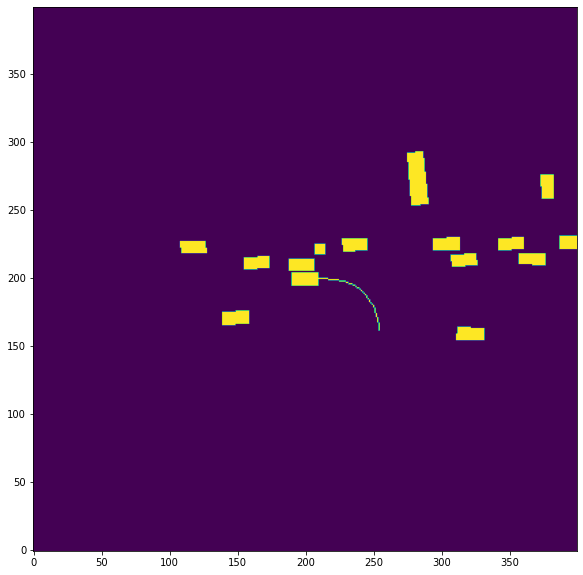

In [30]:
# Looks like car is slowly moving right
plt.figure(figsize=(10, 10))
plt.imshow(vehicles_occupancy_fm, origin='lower')